Sequential Decision Making - Submission Notebook
================================================



## Sequential Decision Making



This notebook will form part of your individual submission for the course. The notebook will roughly mimic the parts that are in the `PDF` worksheet. Your task is to complete the code that is missing in the parts below and answer the questions that we ask. The aim is **not** for you to **solve** the worksheet but rather for you to show your understanding of the material in the course, instead of re-running and aiming to get "perfect" results run things, make sure it is correct and then try to explain your results with a few sentences, what we are looking for is evidence of understanding not the **right** result.

Bayesian optimisation is the first practical use of statistical emulation that we will do in the course. It is a really powerful and useful technique clearly exemplifying the value of having a parametrisation of our *ignorance* about a specific problem so that we can address this. We will use a Gaussian process as a surrogate model but when you go through the notebook you will see that there is nothing in the methodology itself that is tied to this specific surrogage. Given that you have already implemented a Gaussian process model in the previous worksheet, feel free to use that code instead as I am sure it is much better than your Professors attempt at coding :-).

The task we are going to address is that of minimisation. We have some form of unknown function that we can query, we want to find the minimima of this function using as few queries as possible. This is a very general scenario, there is some entity that we can interact with and from this there is a specific quantity of interest that we are interested in.

We are going to use a simple one-dimensional function that you have seen in the lectures and also a classic two-dimensional optimisation function called the Rosenbrock function.



In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import rosen

In [165]:
def f(X, noise=0.0):
    return -(-np.sin(3*X) - X**2 + 0.7*X + noise*np.random.randn(*X.shape))

def Rosenbrock2D(X, noise=0.0):
    # you can evaluate this for any dimensionality if you want to try
    X1, X2 = np.meshgrid(X[:,0], X[:,1])
    f = rosen([X1, X2]).flatten()
    return f + noise*np.random.randn(f.shape[0], 1)

Now lets build our surrogate model.



### Surrogate model



Let us implement the surrogate model, we need a functionality to get the posterior distribution for any location in the space of inputs.



In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import cdist

In [167]:
def gpposterior(x_star,X,Y, theta, kernel_func):
    # theta[0] - variance
    # theta[1] - lengthscale
    # theta[2] - noise variance
    k_starstar = kernel_func(x_star, x_star, theta)
    K = kernel_func(X, X, theta)
    k_starX = kernel_func(x_star, X, theta)

    mu = k_starX.dot(np.linalg.inv(K).dot(Y))
    varSigma = k_starstar - k_starX.dot(np.linalg.inv(K)).dot(k_starX.T)
    
    return mu, varSigma

For the co-variance function, you have already played around a bit with different co-variances in the previous lab, feel free to try a few different ones here as well. We will add one co-variance that you haven't seen before that is very commonly used in Bayesian Optimisation and that is the `Matern Class` of co-variances.



In [168]:
def matern32_kernel(x1, x2, theta):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    return theta[0]*(1+np.sqrt(3)*d/theta[1])*np.exp(-np.sqrt(3)*d/theta[1])

def matern52_kernel(x1, x2, theta):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    return theta[0]*(1+np.sqrt(5)*d/theta[1] + 5*d**2/(3*theta[1]**2))*np.exp(-np.sqrt(5)*d/theta[1])

The Matern family of co-variances share a lot of the behaviour of the RBF, however compared to the former it is not infinitely differentiable which allows us to specify the degree of smoothness the function have allowing for a bit more "roughness" in the function. Actually the class is itself specified with a parameter controlling this and the RBF co-variance is the limiting behaviour of this parameter, so in some sense it is a generalisation of the RBF covariance. To get familiar with the co-variance do just as you did in the previous lab and draw some samples from it.

**Questions 1**
*Explain why you think the Matern co-variance might be a better co-variance function compared to the squared-exponential in the general case?*

**Answer**
Matern co-variance is useful compared to the squared-exponential function / RBF kernel because it enables greater flexibility in identifying/computing our co-variance. That is, because Matern co-variance is parameterized by the $\nu$ (which relates to the "smoothness" of the function), we are able to (A) consider a range of possible co-variance functions (including the squared-exponential as $\nu\rightarrow\infty$), (B) consider a range of flexibilities of kernel functions, and (C) improve our computational efficiency and ability to test samples by limiting the necessity to work over a fully differentiable function. This can be helpful towards capturing sharp changes in the true function being evaluated, including discontinuities. As a result, the Matern class of co-variance functions allows us to model a much broader range of possible behaviors compared to the squared-exponential.


### Acquisition Function



When we have the surrogate model up and running it is time to think about the *strategy* that we use to interact with the function given that we have a surrogate. First lets think about how we can think about the problem at hand. Would it be possible to find the minima of a function given that we would not assume/believe anything about the structure of the function? No, in the case where we expect the minima to be anywhere we cannot get any reduced entropy about it by observing the function. So the key here is, we make assumptions about the function and then see how this leads to a reduced entropy of the minima. So lets look at the information that our function prior encodes.

What we will do is to observe a set of locations to start with, these are just chosen randomly. Then we compute the posterior distribution of the function for a set of location. We will then draw a large set of samples from this distribution, i.e. functions that are consistent with our updated belief given the observations we have seen.

As it is the minima we are interested in we will compute the location of the minima. This is of course not the minima of the actual function, it is only the minima among the slices that we are considering.



In [223]:
np.random.seed(42)
X = np.random.randn(3).reshape(-1,1)
Y = f(X)
x_star = np.linspace(-5,5,200).reshape(-1,1)

kernel_func = matern32_kernel
theta = np.ones((3,1))
mu, varSigma = gpposterior(x_star,X,Y, theta, kernel_func) # generate surrogate belief
f_star = np.random.multivariate_normal(mu.flatten(), varSigma, 1000) # generate samples from the surrogate
x_min = x_star[np.argmin(f_star, axis=1)] # get x values were we believe minima are likely

When you have computed the minima, plot the histogram of the values along the x-axis together with the mean and the marginal variance at each location. You can try this for a few different co-variance functions to see how the structure changes, also try to alter the number of points that you start with etc. just to get a feeling for the information that you have encoded about the minima from the different assumptions that you encode using the co-variance. You can also plot the underlying unknown function and see how well it reflects where the actual minima is.

In [224]:
import seaborn as sns

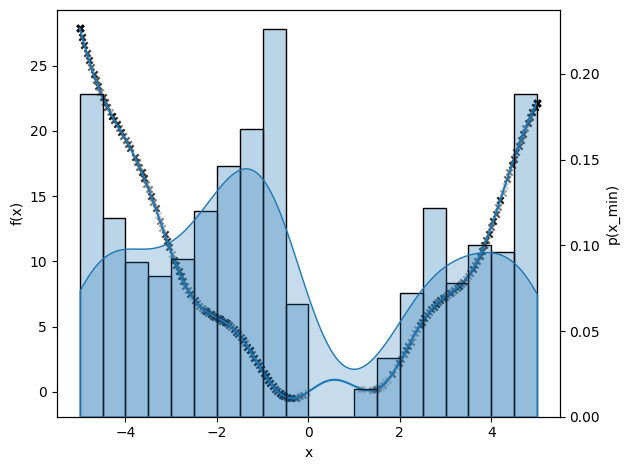

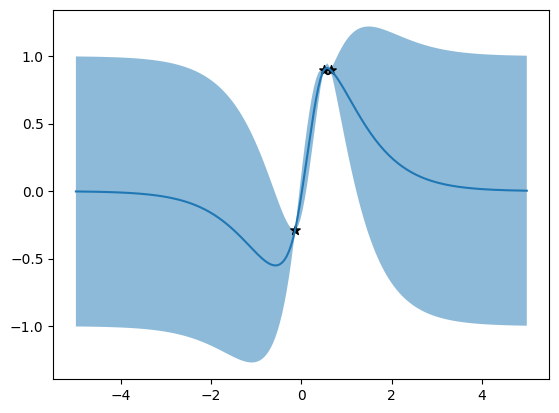

In [227]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.plot(x_star, f(x_star))
ax1.scatter(x_min, f(x_min), alpha=0.2, marker='x', c='black', s=20)

ax2 = ax1.twinx()
ax2.set_ylabel('p(x_min)')

sns.histplot(x_min, legend=False, stat='density', alpha=0.3, ax=ax2, bins=20)
sns.kdeplot(x_min, fill=True, legend=False, ax=ax2, cut=0)

fig.tight_layout()
plt.show()

plt.scatter(X, Y, 50, 'k', '*', zorder=2)
plt.plot(x_star, mu)
plt.fill_between(x_star.flatten(), mu.flatten() - np.sqrt(np.diagonal(varSigma)), mu.flatten() + np.sqrt(np.diagonal(varSigma)), alpha=0.5)

plt.show()

**Question 2**
*The distribution that we have generated above is empirical, meaning that we do not have this in closed form, it is actually intractable to get this distribution in closed form. Explain why this is. You do not have to make a mathematical argument, about this, reason about the distribution and where it comes from will be sufficient.*

**Answer**
It is intractible to get this distribution in closed form, as doing so would require already having (A) an accurate understanding of the underlying function being modelled, and (B) an infinite number of samples to fully describe, which is itself what we are trying to find (thus requiring circuitous reasoning). This is because the distribution is itself dependent on our initial samples from the true function, and also prone to random variations due to the sampling approach, resulting in inconsistent distributions unless generating an infinite number of samples from the surrogate. 

From the argument that we did above, I hope that you agree that our belief over the function actually induces a relevant belief over the minima of the function. Now we want to come up with a strategy that allows us to iteratively query the function in relevant places to create an efficient search. To be a bit general we will think of a function, called the *acquisition function*, that will parametrise the strategy we use for the finding the minima. In specific, the function will provide a value telling us the "relative" value of querying a specific location in the input domain. 

Now lets considered the simplest strategy that does this is to rather than compute the empirical distribution of the minima and sample from this, just pick one of the sampled functions and use its minima. This is a technique referred to as *Thompson Sampling*. In terms of an acquisition this means that we will generate a function that has a non-zero value at the location of the minima of the sample and is zero everywhere else.



In [1]:
def thompson_sampling(f_star, mu, varSigma):
    f = np.random.multivariate_normal(mu.flatten(), varSigma, 1)
    x_new = np.argmin(f, axis=1)
    alpha = np.zeros(mu.flatten().shape)
    alpha[x_new] = 1
    
    return alpha

Now we have the two components that we need in order to write our iterative Bayesian Optmisation loop. We are going to be trying out a few different co-variance functions and acquisition strategies so if you can try to write the code in a general manner where these things are easy to swap out. Because we are using non-parametric surrogates, we have to decide upon a finite set of locations to evaluate our surrogate and acquisition function on. In effect we are trying to answer the question, *from a finite set locations $\{\mathbf{x}_i\in\mathcal{X}\}_{i=1}^N$ what is location that corresponds to the minimal function value in the set $\{\mathbf{x}_i\}_{i=1}^N$*. In practice we will just use a uniform grid as the sample location. Now lets implement the loop,



In [1]:
def bayesian_optimisation(surrogate_model, acquisition_function, X):
    #0.1 pick some initial starting function evaluations

    while(): #some stopping criteria
        #1. Compute surrogate posterior on current data D = {X,f}
        
        #2. Compute Acquisition function

        #3. Find maximum value of acquisition x_*

        #4. Evaluate function at x_*

        #5. Add new data f(x_*), x_* to D
    
    return f_min, x_min

Once you have confirmed that the loop is running in a way that you would expect try to alter the co-variance function, either its parameters or the type just so that you get and understanding of how the loop works.

**Question 3**
*Give one positive and one negative argument for Thompson sampling as an acquisition function.*

**Answer**

Now let us think about a different strategy for doing the acquisition. Probably the most common approach is an approach called *Expected Improvement*. Expected improvement is defined through the notion of the following *utility*,
$$
u(x) = \textrm{max}(0, f(x_*)-f(x)),
$$
taking the expected utility given our current knowledge of the function leads to the acquisition function,
$$
\alpha(x) = \mathbb{E}\left[u(x)\vert x, \mathcal{D} \right] = \int_{-\infty}^{f(x_*)} (f(x_*)-f(x))\mathcal{N}(f\vert \mu(x), k(x,x))\textrm{d}f.
$$

**Question 4**
*Explain why the limits on the integral is $f(x_*)$ and $-\infty$? What would the limits be if we performed **maximisation** instead of **minimisation**?*

**Answer**

Below is the implementation of the expected improvement acquisition function.



In [1]:
from scipy.stats import norm
def expected_improvement(f_star, mu, varSigma):
    alpha = np.zeros(mu.shape)
    for i in range(0,X.shape[0]):
        alpha[i] = (f_star-mu[i])*norm.cdf(f_star,mu[i],np.sqrt(varSigma[i])) + varSigma[i]*norm.pdf(f_star,mu[i],np.sqrt(varSigma[i]))
    return alpha

**Question 5**
*Contrast expected improvement with Thompson sampling, how do they explore the domain differently?*

**Answer**

Once you have the above code up and running you should be able to reproduce the results that are in Figure 1 in the worksheet and the images that are in the lecture notes. Make sure that you are completely confident in what is happening, why it is happening, and what different "design" choices that you have.



### Experiments



We are now going to run some experiments to try and learn more about the Bayesian optimisation loop. So far we have looked at 1-dimensional function. The function is actually too easy for the methods that we have and some of the changes that we would have expected between the different experiments might not be as evident as we would like. You can therefore try the two-dimensional Rosenbrock function and make your arguments on that function instead.

The methodology have several different choices and several sources of stochasticity. To understand how this effects the loop we will do a plot called a *regret* plot. In this plot the `x-axis` is the number of function evaluations and the `y-axis` is the current regret. The regret is defined as the difference between the current best value and the optimal value in the set. Given that the functions that we are working here are quite cheap to compute you can just evaluate the function over the whole set to get the optimal value. Given that we have stochasticity in the loop different runs will lead to difference curves therefore plot the mean and two standard deviations for each iterations. It is also quite useful to know the best and worst value that you get so also plot these.

The first experiment that we are going to look at is the effect of the co-variance parameters. The easiest one to see is to look at the length-scale parameter. Generate a regret plot, where you change the length-scale from a very small value to a very large. For this experiment we will fix the stochasticity in the system so before you run the experiment set the random seed in `numpy` using `np.random.seed(42)`. This means that you only need to do a single run for each of the setting.



In [1]:
# test the co-variance parameters
np.random.seed(42)
lengthScales = np.linspace(, 10)
for i in range(0,10):

**Question 6**
*Explain why the regret plot looks the way it does. Reason about what the "optimal" lengthscale would be, say that your function is a sample from a GP with lengtscale $\ell$ would having the same lengthscale be the optimal lengthscale for the surrogate? Explain your reasoning.*

**Answer**

Now lets pick a lengthscale that seems sensible and fix the surrogate model. We are going to look at the stochastic part of the loop and look at the effect of the initial start locations. Lets first play with the number of start locations. Do a regret plot where you show the total evaluations of the function on the x-axis including the number of starting locations. Because we are picking the start locations randomly you will have do multiple runs for each value and your regret plot will therefore have a variance.



In [1]:
# generate the regret plot for the number of start locations
for i in range(1,7):
    for j in range(0, n_starts):
        # generate start locations
        for k in range(0, n_evals):

Finally generate a regret plot with lots of runs for $3$ starting locations. 

**Question 7**
*Explain the plots that you see and why you see the behaviour that you do.*

**Answers**

Let us try make the function a bit more challenging by adding a bit of noise to the function. We will keep the number of starting locations to $3$.



In [1]:
# implement a loop that tries different noise-levels
for i in range(0, 10):
    y = f(x, noise[i])
    for j in range(0, n_starts):
        for k in range(0, n_evals):

Finally make a final experiment where you use a surrogate model that matches the amount of noise as you add to the data.

**Question 8**
*Explain the results by contrasting to the previous none-noisy evaluation. How does the "best" run compare to the "best" run in the previous example?*

**Answer**

As you probably noticed the effect of the hyper-parameters is quite significant. Explain how you think we should approach a problem where we are uncertain about the hyper-parameters? One approach would be to actually updated the hyper-parameters with a gradient based optimiser as we did in the last part of the previous lab. However, you do not need to do this as it is going to add a lot of computations as you are doing this inside the inner-loop and with the computational issues that you saw in the last lab it we need to think about numerical stability before we do this. Instead try to reason about it, don't worry about right or wrong here, I just want to hear your thoughts around this issue.

**Question 9**
*What do you think is a good strategy for dealing with the hyper-parameters of the model?*

**Answer**



### Submission



Now you can submit the notebook on `Moodle`. The deadline for the submission is Friday the 3rd of November at 12:00.

